In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize
from scipy import stats
import statsmodels.api as sm
import seaborn as sns


### Reading monthly returns

Monthly figures, we have end-of-month data, not always prefectly aligned to the end of month

In [2]:
USD_monthly_returns = pd.read_csv('data/US_value_weighted_returns.csv', parse_dates=['date'], index_col='date')

japan       = pd.read_csv("data/JAPAN.csv",       parse_dates=["date"], index_col="date")[["mportret"]]
australia   = pd.read_csv("data/AUSTRALIA.csv",   parse_dates=["date"], index_col="date")[["mportret"]]
germany     = pd.read_csv("data/GERMANY.csv",     parse_dates=["date"], index_col="date")[["mportret"]]
france      = pd.read_csv("data/FRANCE.csv",      parse_dates=["date"], index_col="date")[["mportret"]]
switzerland = pd.read_csv("data/SWITZERLAND.csv", parse_dates=["date"], index_col="date")[["mportret"]]
unitedkingdom = pd.read_csv("data/UNITEDKINGDOM.csv", parse_dates=["date"], index_col="date")[["mportret"]]

switzerland.head()

,mportret
date,
2000-01-31,-0.072023
2000-02-29,-0.001949
2000-03-31,0.081995
2000-04-28,0.002559
2000-05-31,0.042735


### Reading exchange rates

Monthly figures, we have beginning-of-month data

In [3]:
def load_fx_series(filepath: str, invert: bool = False) -> pd.Series:
    """Load FX series and convert to currency → USD if needed."""
    df = pd.read_csv(filepath, parse_dates=['observation_date'], index_col='observation_date')
    series = df.iloc[:, 0]
    return 1 / series if invert else series

# Load FX rates (all to USD)
fx_jpy = load_fx_series('data/EXJPUS.csv', invert=True)   # JPY → USD
fx_chf = load_fx_series('data/EXSZUS.csv', invert=True)   # CHF → USD
fx_aud = load_fx_series('data/EXUSAL.csv')                # AUD → USD
fx_eur = load_fx_series('data/EXUSEU.csv')                # EUR → USD
fx_gbp = load_fx_series('data/EXUSUK.csv')                # GBP → USD

# Preview one of the results
fx_chf.tail()
fx_jpy.tail()
fx_gbp.tail()

observation_date
2024-08-01    1.2945
2024-09-01    1.3219
2024-10-01    1.3043
2024-11-01    1.2738
2024-12-01    1.2647
Name: EXUSUK, dtype: float64

FX are beginning of month, returns are end of months --> we will shift back FX to previous month, we will also push returns to exactly end of month.

In [4]:
def align_returns_to_month_end(ret_df: pd.DataFrame) -> pd.DataFrame:
    """
    Take a returns DataFrame (or Series) whose index is a date somewhere
    in a month, and “snap” that date to the LAST calendar day of the same month.

    E.g. 2000-04-28 → 2000-04-30; 2000-02-29 → 2000-02-29; 2000-06-30 → 2000-06-30.
    """
    df = ret_df.copy()
    df.index = df.index.to_period("M").to_timestamp("M")
    return df

def align_fx_to_previous_month_end(fx_obj) -> pd.DataFrame:
    """
    Take an FX Series or single‐column DataFrame whose index is ANY date 
    in a month (e.g. 2000-05-01 or 2000-05-15), and move that entire index 
    to the *previous* month’s last calendar day.

    - If fx_obj.index is a DatetimeIndex:  (ix.to_period("M") - 1).to_timestamp("M")
    - If fx_obj.index is already a PeriodIndex:        (ix - 1).to_timestamp("M")
    """
    # Copy it so we do not mutate the original
    df = fx_obj.copy()
    ix = df.index

    if isinstance(ix, pd.DatetimeIndex):
        df.index = (ix.to_period("M") - 1).to_timestamp("M")

    elif isinstance(ix, pd.PeriodIndex):
        df.index = (ix - 1).to_timestamp("M")

    else:
        dt = pd.to_datetime(ix)
        df.index = (dt.to_period("M") - 1).to_timestamp("M")

    return df

In [5]:
def merge_one_country(returns_df: pd.DataFrame, fx_obj) -> pd.DataFrame:
    """
    1) Snap returns_df index to the SAME month‐end.
    2) Snap fx_obj (Series or DataFrame) index to the PREVIOUS month‐end.
    3) Rename columns to 'return' and 'fx'.
    4) Merge on that common index (inner join).
    """
    # --- Step 1: Align returns to month‐end (same month).
    ret_aligned = align_returns_to_month_end(returns_df)
    ret_aligned = ret_aligned.rename(columns={ret_aligned.columns[0]: "return"})
    
    # --- Step 2: Align FX backward to previous month‐end.
    fx_aligned = align_fx_to_previous_month_end(fx_obj)
    
    # If fx_aligned is a Series, convert it to a DataFrame named "fx".
    if isinstance(fx_aligned, pd.Series):
        fx_aligned = fx_aligned.to_frame(name="fx")
    else:
        # Otherwise it's already a DataFrame with one column—rename that column to "fx"
        fx_aligned = fx_aligned.rename(columns={fx_aligned.columns[0]: "fx"})
    
    # --- Step 3: Inner‐merge on the aligned index.
    merged = pd.merge(
        ret_aligned,
        fx_aligned,
        left_index=True,
        right_index=True,
        how="inner"
    )
    return merged



In [6]:
returns_dict = {
    "japan":       japan,
    "australia":   australia,
    "germany":     germany,
    "france":      france,
    "switzerland": switzerland,
    "unitedkingdom": unitedkingdom
}

fx_dict = {
    "japan":         fx_jpy,   
    "switzerland":   fx_chf,   
    "australia":     fx_aud,   
    "germany":       fx_eur,   
    "france":        fx_eur,   
    "unitedkingdom": fx_gbp    
}

merged_data = {}

for country in returns_dict.keys():
    # grab raw returns DataFrame + raw FX (Series or DF) for this country
    raw_ret = returns_dict[country]
    raw_fx  = fx_dict[country]

    merged_df = merge_one_country(raw_ret, raw_fx)
    merged_data[country] = merged_df


for country in merged_data.keys():
    merged_data[country] = merged_data[country][merged_data[country].index >= '2002-01-01']


In [7]:
merged_data["japan"].head()

,return,fx
2002-01-31,-0.056655,0.007483
2002-02-28,0.042256,0.007630
2002-03-31,0.053119,0.007647
2002-04-30,0.020586,0.007913
2002-05-31,0.035987,0.008111


# 3.a. Returns of each index in USD

In [8]:
def compute_usd_returns(merged_data: dict) -> dict:
    """
    Given:
      - merged_data: a dict mapping country_name → DataFrame
        where each DataFrame has exactly two columns:
           'return' (local index return, aligned to month‐end)
           'fx'     (USD exchange rate, aligned to previous month‐end)
    
    This function:
      1. Copies each country’s DataFrame.
      2. Computes fx_return = fx / fx.shift(1) - 1
      3. Computes usd_return = (1 + return) * (1 + fx_return) - 1
      4. Drops any rows with NaNs (from the shift).
      5. Returns a new dict (same keys) whose DataFrames now contain:
         ['return', 'fx', 'fx_return', 'usd_return'].
    """
    processed_data = {}
    
    for country, df_original in merged_data.items():
        # 1) Make a copy so we don’t overwrite the original
        df = df_original.copy()
        
        # 2) Compute the monthly FX return
        #    (percent change in the USD/FX rate from previous row → current row)
        df['fx_return'] = df['fx'] / df['fx'].shift(1) - 1
        
        # 3) Compute the USD‐denominated total return:
        #    (1 + local_index_return) * (1 + fx_return) − 1
        df['usd_return'] = (1 + df['return']) * (1 + df['fx_return']) - 1
        
        # 4) Drop any rows with NaNs (the first row will become NaN in fx_return)
        df.dropna(inplace=True)
        
        # 5) Store the result under the same country key
        processed_data[country] = df
    
    return processed_data

In [9]:
processed_data = compute_usd_returns(merged_data)
processed_data["switzerland"].head(10)

,return,fx,fx_return,usd_return
2002-02-28,0.011661,0.597265,0.013558,0.025377
2002-03-31,0.048759,0.604522,0.012151,0.061503
2002-04-30,-0.004109,0.629366,0.041098,0.036820
2002-05-31,0.002963,0.649393,0.031820,0.034877
2002-06-30,-0.081687,0.679440,0.046270,-0.039197
2002-07-31,-0.132371,0.667913,-0.016965,-0.147091
2002-08-31,0.005083,0.669748,0.002746,0.007842
2002-09-30,-0.089463,0.669703,-0.000067,-0.089524
2002-10-31,0.030385,0.682221,0.018693,0.049646
2002-11-30,0.037936,0.695024,0.018766,0.057414


# 3.b. Currency-hedged index return

Initializing correct data, start with interbank rates

In [10]:
#    Read each 3-month interbank CSV, parse the "observation_date" column as DatetimeIndex,
#    select only the rate column, and rename it to the correct ISO code.

aus_ib = pd.read_csv(
    "data/AUSTRALIA_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
aus_ib = aus_ib.iloc[:, [0]].rename(columns={aus_ib.columns[0]: "AUD"})
aus_ib["AUD"] = aus_ib["AUD"] / 100


eur_ib = pd.read_csv(
    "data/EUROPE_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
eur_ib = eur_ib.iloc[:, [0]].rename(columns={eur_ib.columns[0]: "EUR"})
eur_ib["EUR"] = eur_ib["EUR"] / 100


gbp_ib = pd.read_csv(
    "data/GREATBRITAIN_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
gbp_ib = gbp_ib.iloc[:, [0]].rename(columns={gbp_ib.columns[0]: "GBP"})
gbp_ib["GBP"] = gbp_ib["GBP"] / 100


jpy_ib = pd.read_csv(
    "data/JAPAN_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
jpy_ib = jpy_ib.iloc[:, [0]].rename(columns={jpy_ib.columns[0]: "JPY"})
jpy_ib["JPY"] = jpy_ib["JPY"] / 100


chf_ib = pd.read_csv(
    "data/SWITZERLAND_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
chf_ib = chf_ib.iloc[:, [0]].rename(columns={chf_ib.columns[0]: "CHF"})
chf_ib["CHF"] = chf_ib["CHF"] / 100

usd_ib = pd.read_csv(
    "data/USA_IB.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
)
usd_ib = usd_ib.iloc[:, [0]].rename(columns={usd_ib.columns[0]: "USD"})
usd_ib["USD"] = usd_ib["USD"] / 100

# Combine all six DataFrames side-by-side (inner join on the common dates)
ibexr = pd.concat(
    [usd_ib, eur_ib, jpy_ib, gbp_ib, chf_ib, aus_ib],
    axis=1,
    join="inner"
)

# Ensure the index is sorted and is exactly at month-end
ibexr.index = pd.to_datetime(ibexr.index)
ibexr = ibexr.sort_index()

ibexr = ibexr.resample("M").last().dropna(how="all")

print(ibexr.head())


                     USD       EUR     JPY       GBP       CHF     AUD
observation_date                                                      
2002-04-30        0.0187  0.034069  0.0010  0.041732  0.014606  0.0459
2002-05-31        0.0182  0.034671  0.0008  0.041537  0.011635  0.0484
2002-06-30        0.0181  0.034640  0.0009  0.041776  0.011496  0.0507
2002-07-31        0.0179  0.034100  0.0009  0.040605  0.010031  0.0498
2002-08-31        0.0173  0.033519  0.0007  0.039865  0.006683  0.0496


C:\Users\Karl\AppData\Local\Temp\ipykernel_19572\2980223554.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ibexr = ibexr.resample("M").last().dropna(how="all")


In [11]:
iso_map = {
    "japan":         "JPN",
    "australia":     "AUS",
    "germany":       "DEU",
    "france":        "FRA",
    "switzerland":   "CHE",
    "unitedkingdom": "GBR"
}

idx_returns = pd.DataFrame({
    iso_map[country]: df["usd_return"]
    for country, df in processed_data.items()
})
idx_returns.index = pd.to_datetime(idx_returns.index)
idx_returns = idx_returns.sort_index()

cexr = pd.DataFrame({
    "JPY": processed_data["japan"]["fx"],
    "CHF": processed_data["switzerland"]["fx"],
    "AUD": processed_data["australia"]["fx"],
    "EUR": processed_data["germany"]["fx"],
    "GBP": processed_data["unitedkingdom"]["fx"]
})
cexr.index = pd.to_datetime(cexr.index)
cexr = cexr.sort_index()

idx_returns.head()

,JPN,AUS,DEU,FRA,CHE,GBR
2002-02-28,0.062786,0.023083,-0.002091,0.002352,0.025377,-0.003130
2002-03-31,0.055448,0.023559,0.060580,0.063363,0.061503,0.053459
2002-04-30,0.056094,0.012587,-0.011617,-0.010538,0.036820,-0.001806
2002-05-31,0.061906,0.033256,0.015840,0.013428,0.034877,0.004702
2002-06-30,-0.041866,-0.051421,-0.032251,-0.044850,-0.039197,-0.037508


In [12]:
ibexr.to_csv("data/ibexr.csv")
idx_returns.to_csv("data/idx_returns.csv")
cexr.to_csv("data/cexr.csv")

## New implementation of currency hedging

In [13]:
# From now on, we truncate dataframes to all start from 2002-04
ibexr = ibexr[ibexr.index >= '2002-04']
cexr = cexr[cexr.index >= '2002-04']
idx_returns = idx_returns[idx_returns.index >= '2002-04']

# Convert annual interbank rates to monthly by dividing by 12
ibexr_monthly = ibexr / 12

# Create the country-currency mapping based on your data
country_currency_map = {
    'JPN': 'JPY',
    'AUS': 'AUD', 
    'DEU': 'EUR',
    'FRA': 'EUR',
    'CHE': 'CHF',
    'GBR': 'GBP'
}

# Initialize DataFrames for results
excess_return_currency_in_USD = pd.DataFrame(index=ibexr_monthly.index)
currency_hedged_index_return = pd.DataFrame(index=excess_return_currency_in_USD.index)

# Calculate currency hedged returns for each country
for country, currency in country_currency_map.items():
    fact = cexr[currency] / cexr[currency].shift(1)
    foreign_rate = ibexr_monthly[currency]  # Use currency column from ibexr
    us_rate = ibexr_monthly['USD']
    X = fact * (1 + foreign_rate) - (1 + us_rate)
    excess_return_currency_in_USD[country + '_currency_excess_return'] = X
    currency_hedged_index_return[country + '_currency_hedged_return'] = idx_returns[country] - X

excess_return_currency_in_USD.dropna(inplace=True)
currency_hedged_index_return.dropna(inplace=True)

# Display results
print("Currency Excess Returns in USD:")
print(excess_return_currency_in_USD.head())
print("\nCurrency Hedged Index Returns:")
print(currency_hedged_index_return.head())

Currency Excess Returns in USD:
                  JPN_currency_excess_return  AUS_currency_excess_return  \
observation_date                                                           
2002-05-31                          0.023570                    0.036118   
2002-06-30                          0.044299                   -0.022734   
2002-07-31                         -0.010608                   -0.020007   
2002-08-31                         -0.018607                    0.012338   
2002-09-30                         -0.024239                    0.009431   

                  DEU_currency_excess_return  FRA_currency_excess_return  \
observation_date                                                           
2002-05-31                          0.044135                    0.044135   
2002-06-30                          0.040608                    0.040608   
2002-07-31                         -0.014195                   -0.014195   
2002-08-31                          0.003915           

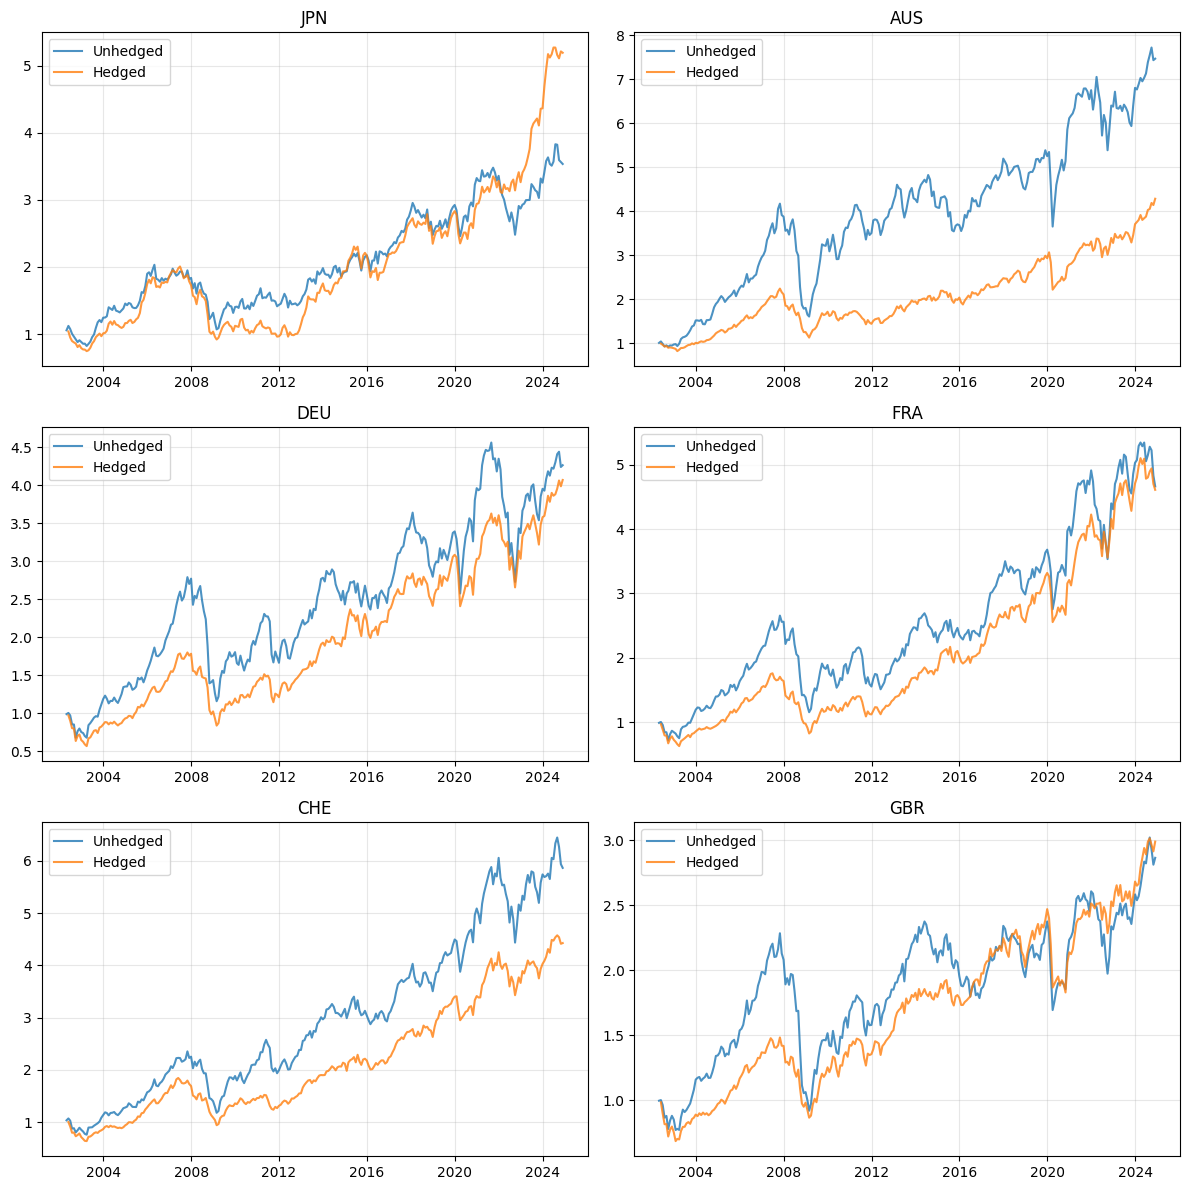

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

countries = ['JPN', 'AUS', 'DEU', 'FRA', 'CHE', 'GBR']

for i, country in enumerate(countries):
    # Cumulative returns
    unhedged_cum = (1 + idx_returns[country]).cumprod()
    hedged_cum = (1 + currency_hedged_index_return[country + '_currency_hedged_return']).cumprod()
    
    axes[i].plot(unhedged_cum, label='Unhedged', alpha=0.8)
    axes[i].plot(hedged_cum, label='Hedged', alpha=0.8)
    axes[i].set_title(country)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Step 1: Check one country in detail - let's use JPN
print("=== DEBUGGING JPN CURRENCY HEDGING ===")
country = 'JPN'
currency = 'JPY'

# Check the data alignment first
print(f"\n1. Data ranges:")
print(f"cexr range: {cexr.index.min()} to {cexr.index.max()}")
print(f"ibexr range: {ibexr_monthly.index.min()} to {ibexr_monthly.index.max()}")
print(f"idx_returns range: {idx_returns.index.min()} to {idx_returns.index.max()}")

# Pick a specific date to trace through
test_date_idx = 10
test_date = cexr.index[test_date_idx]
print(f"\n2. Testing date: {test_date}")

# Check FX data
fx_current = cexr[currency].iloc[test_date_idx]
fx_previous = cexr[currency].iloc[test_date_idx-1] 
fact = fx_current / fx_previous
print(f"FX current: {fx_current:.6f}")
print(f"FX previous: {fx_previous:.6f}")
print(f"FX factor (St+1/St): {fact:.6f}")

# Check interest rates
foreign_rate = ibexr_monthly[currency].iloc[test_date_idx]
us_rate = ibexr_monthly['USD'].iloc[test_date_idx]
print(f"Foreign rate (monthly): {foreign_rate:.6f}")
print(f"US rate (monthly): {us_rate:.6f}")

# Calculate X step by step
term1 = fact * (1 + foreign_rate)
term2 = (1 + us_rate)
X = term1 - term2
print(f"\n3. Currency excess return calculation:")
print(f"fact * (1 + foreign_rate) = {fact:.6f} * {1 + foreign_rate:.6f} = {term1:.6f}")
print(f"(1 + us_rate) = {term2:.6f}")
print(f"X = {term1:.6f} - {term2:.6f} = {X:.6f}")

# Check the original return
original_return = idx_returns[country].iloc[test_date_idx]
hedged_return = original_return - X
print(f"\n4. Final calculation:")
print(f"Original return: {original_return:.6f}")
print(f"Currency excess return (X): {X:.6f}")
print(f"Hedged return: {original_return:.6f} - {X:.6f} = {hedged_return:.6f}")

# Sanity check: if JPY strengthens, US investor should benefit from unhedged
if fact > 1:
    print(f"\n5. Sanity check: JPY strengthened (factor > 1)")
    print(f"   Unhedged should be BETTER than hedged")
    print(f"   Unhedged: {original_return:.6f}, Hedged: {hedged_return:.6f}")
else:
    print(f"\n5. Sanity check: JPY weakened (factor < 1)")  
    print(f"   Hedged should be BETTER than unhedged")
    print(f"   Unhedged: {original_return:.6f}, Hedged: {hedged_return:.6f}")

=== DEBUGGING JPN CURRENCY HEDGING ===

1. Data ranges:
cexr range: 2002-04-30 00:00:00 to 2024-11-30 00:00:00
ibexr range: 2002-04-30 00:00:00 to 2024-12-31 00:00:00
idx_returns range: 2002-04-30 00:00:00 to 2024-11-30 00:00:00

2. Testing date: 2003-02-28 00:00:00
FX current: 0.008426
FX previous: 0.008380
FX factor (St+1/St): 1.005483
Foreign rate (monthly): 0.000075
US rate (monthly): 0.001058

3. Currency excess return calculation:
fact * (1 + foreign_rate) = 1.005483 * 1.000075 = 1.005559
(1 + us_rate) = 1.001058
X = 1.005559 - 1.001058 = 0.004500

4. Final calculation:
Original return: 0.002519
Currency excess return (X): 0.004500
Hedged return: 0.002519 - 0.004500 = -0.001981

5. Sanity check: JPY strengthened (factor > 1)
   Unhedged should be BETTER than hedged
   Unhedged: 0.002519, Hedged: -0.001981


# 3.c. Diversification 

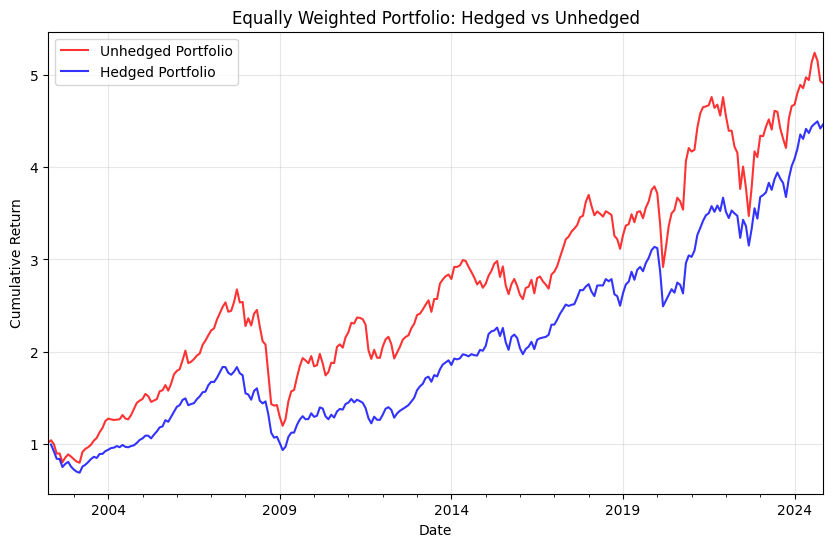

In [16]:
# Calculate equally weighted portfolio returns
portfolio_unhedged = idx_returns.mean(axis=1)
portfolio_hedged = currency_hedged_index_return.mean(axis=1)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
(1 + portfolio_unhedged).cumprod().plot(label='Unhedged Portfolio', color='red', alpha=0.8)
(1 + portfolio_hedged).cumprod().plot(label='Hedged Portfolio', color='blue', alpha=0.8)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Equally Weighted Portfolio: Hedged vs Unhedged')
plt.grid(True, alpha=0.3)
plt.show()

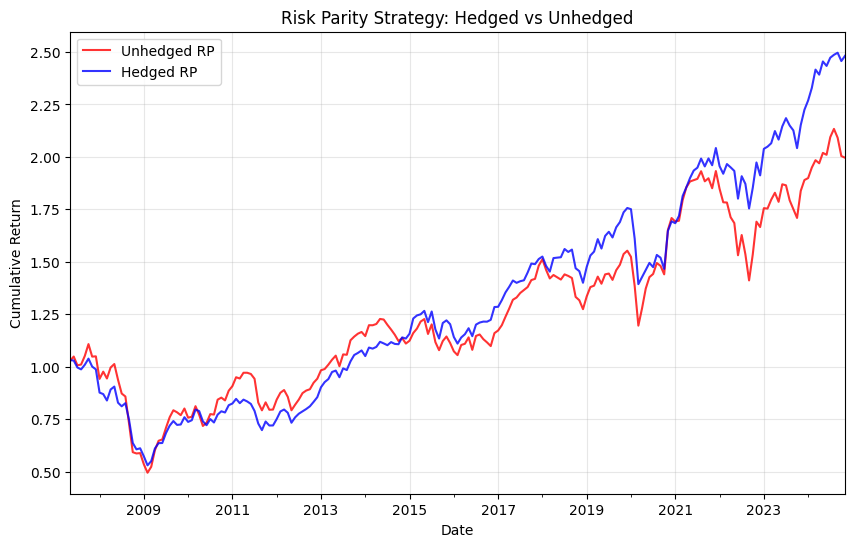

In [17]:
# Risk Parity function
def risk_parity_strategy(returns_df, window=60):
    vol_rolling = returns_df.rolling(window=window, min_periods=window).std()
    inv_vol = 1.0 / vol_rolling
    inv_vol.replace([np.inf, -np.inf], np.nan, inplace=True)
    total_inv_vol = inv_vol.sum(axis=1)
    weights = inv_vol.div(total_inv_vol, axis=0)
    lagged_weights = weights.shift(1)
    portfolio_rets = (lagged_weights * returns_df).sum(axis=1)
    return portfolio_rets, weights

# Calculate risk parity returns
rp_unhedged, weights_unhedged = risk_parity_strategy(idx_returns)
rp_hedged, weights_hedged = risk_parity_strategy(currency_hedged_index_return)

# Remove first 5 years
rp_unhedged = rp_unhedged[rp_unhedged.index >= '2007-05']
rp_hedged = rp_hedged[rp_hedged.index >= '2007-05']

# Plot cumulative returns
plt.figure(figsize=(10, 6))
(1 + rp_unhedged).cumprod().plot(label='Unhedged RP', color='red', alpha=0.8)
(1 + rp_hedged).cumprod().plot(label='Hedged RP', color='blue', alpha=0.8)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Risk Parity Strategy: Hedged vs Unhedged')
plt.grid(True, alpha=0.3)
plt.show()

Computing unhedged Markowitz portfolio...
Computing hedged Markowitz portfolio...


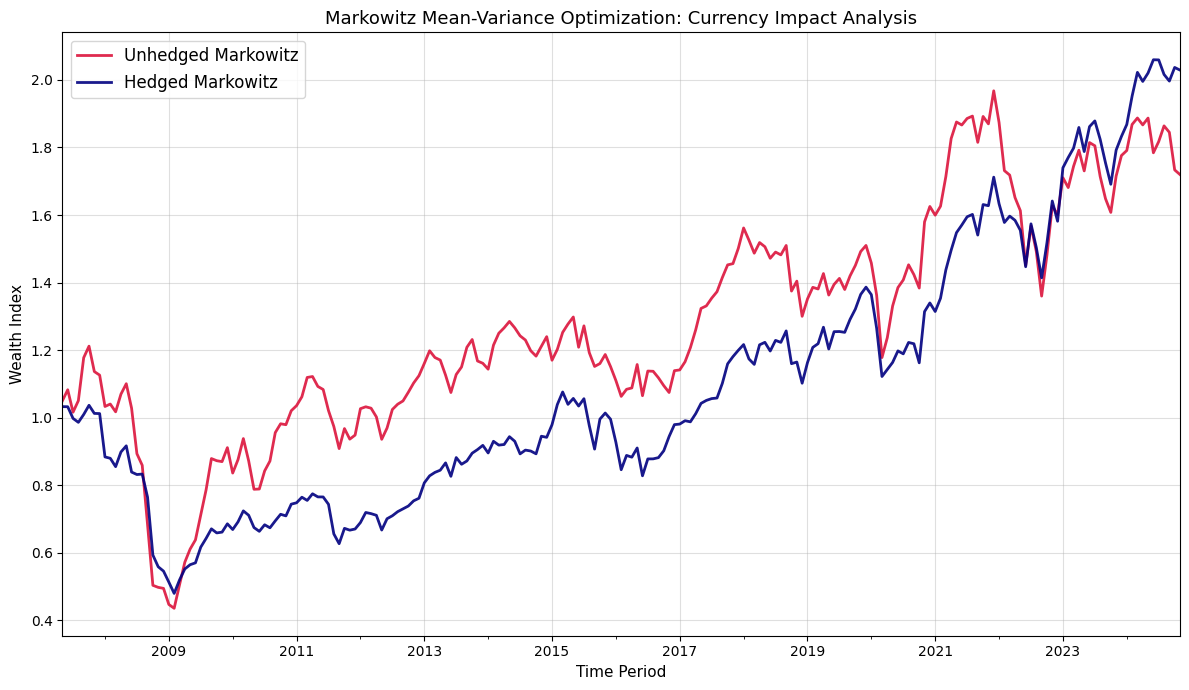

Unhedged final wealth: 1.720
Hedged final wealth: 2.029


In [18]:
from scipy.optimize import minimize
import numpy as np

# Markowitz Portfolio Optimizer
def markowitz_solver(sigma_matrix, mu_vector, risk_free, risk_aversion=1):
    asset_count = len(mu_vector)
    
    # Utility maximization: maximize expected return - (risk_aversion/2) * variance
    utility_func = lambda weights: -(np.dot(mu_vector - risk_free*np.ones(asset_count), weights) - 
                                   0.5 * risk_aversion * np.dot(weights.T, np.dot(sigma_matrix, weights)))
    
    # Portfolio weights must sum to 1
    budget_constraint = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    
    # Equal weight starting point
    initial_guess = np.ones(asset_count) / asset_count
    
    # Long-only constraints (no shorting)
    weight_bounds = [(0, 1) for _ in range(asset_count)]
    
    solution = minimize(utility_func, initial_guess, method='SLSQP', 
                       bounds=weight_bounds, constraints=budget_constraint)
    
    return solution.x

def rolling_portfolio_optimizer(asset_returns):
    # Calculate rolling statistics
    rolling_means = asset_returns.rolling(window=60).mean()
    rolling_covariances = asset_returns.rolling(window=60).cov().bfill()
    
    # Get risk-free rate data
    treasury_rates = ibexr_monthly.loc[:, ['USD']]
    treasury_rates.index = pd.to_datetime(treasury_rates.index)
    
    # Find overlapping time periods
    shared_periods = asset_returns.index.intersection(treasury_rates.index)
    rf_rates = treasury_rates.loc[shared_periods].values.flatten()
    
    # Filter data to shared periods
    filtered_returns = asset_returns.loc[shared_periods]
    filtered_means = rolling_means.loc[shared_periods]
    filtered_covs = rolling_covariances.loc[shared_periods]
    
    # Initialize weight container
    weight_history = []
    
    # Fill initial periods with equal weights
    n_assets = len(asset_returns.columns)
    warmup_period = 60
    
    for period in range(warmup_period):
        weight_history.append(np.ones(n_assets) / n_assets)
    
    # Optimize for each period after warmup
    optimization_periods = len(filtered_means) - warmup_period
    
    for t in range(optimization_periods):
        period_idx = t + warmup_period
        
        # Extract period statistics
        period_means = filtered_means.iloc[period_idx].values
        
        # Get covariance matrix for this period
        cov_start = period_idx
        cov_end = period_idx + n_assets
        period_cov = filtered_covs.iloc[cov_start:cov_end].values.reshape(n_assets, n_assets)
        
        # Optimize portfolio
        optimal_weights = markowitz_solver(period_cov, period_means, rf_rates[period_idx])
        weight_history.append(optimal_weights)
    
    # Create weights dataframe
    weights_df = pd.DataFrame(weight_history, index=shared_periods, columns=asset_returns.columns)
    
    # Normalize weights (defensive programming)
    weights_df = weights_df.div(weights_df.sum(axis=1), axis=0)
    
    return weights_df

def portfolio_backtest(returns_data, allocation_weights):
    # Synchronize data
    overlap_dates = returns_data.index.intersection(allocation_weights.index)
    synced_returns = returns_data.loc[overlap_dates]
    synced_weights = allocation_weights.loc[overlap_dates]
    
    # Use lagged weights (realistic implementation)
    lagged_allocations = synced_weights.shift(1)
    
    # Compute weighted portfolio returns
    portfolio_performance = (lagged_allocations * synced_returns).sum(axis=1)
    
    return portfolio_performance.dropna()

# Execute optimization for both strategies
print("Computing unhedged Markowitz portfolio...")
unhedged_allocations = rolling_portfolio_optimizer(idx_returns)
unhedged_performance = portfolio_backtest(idx_returns, unhedged_allocations)

print("Computing hedged Markowitz portfolio...")
hedged_allocations = rolling_portfolio_optimizer(currency_hedged_index_return)
hedged_performance = portfolio_backtest(currency_hedged_index_return, hedged_allocations)

# Apply lookback filter (remove initial years)
unhedged_performance = unhedged_performance[unhedged_performance.index >= '2007-05']
hedged_performance = hedged_performance[hedged_performance.index >= '2007-05']

# Visualization
plt.figure(figsize=(12, 7))
wealth_unhedged = (1 + unhedged_performance).cumprod()
wealth_hedged = (1 + hedged_performance).cumprod()

wealth_unhedged.plot(label='Unhedged Markowitz', color='crimson', linewidth=2, alpha=0.9)
wealth_hedged.plot(label='Hedged Markowitz', color='navy', linewidth=2, alpha=0.9)

plt.legend(fontsize=12)
plt.xlabel('Time Period', fontsize=11)
plt.ylabel('Wealth Index', fontsize=11)
plt.title('Markowitz Mean-Variance Optimization: Currency Impact Analysis', fontsize=13)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Unhedged final wealth: {wealth_unhedged.iloc[-1]:.3f}")
print(f"Hedged final wealth: {wealth_hedged.iloc[-1]:.3f}")

## Performance analysis

In [19]:
# Performance comparison function
def portfolio_performance_SR(returns, risk_free_rate):
    mean = (returns.mean()) * 12
    standard_dev = (returns.std()) * np.sqrt(12)
    SR = (mean - risk_free_rate.mean()) / standard_dev
    return mean, standard_dev, SR

# Create comparison dataframe using all our strategies
comparative_df = pd.DataFrame.from_dict({
    'Unhedged EW': portfolio_performance_SR(portfolio_unhedged, ibexr_monthly['USD']),
    'Hedged EW': portfolio_performance_SR(portfolio_hedged, ibexr_monthly['USD']),
    'Unhedged RP': portfolio_performance_SR(rp_unhedged, ibexr_monthly['USD']),
    'Hedged RP': portfolio_performance_SR(rp_hedged, ibexr_monthly['USD']),
    'Unhedged MVO': portfolio_performance_SR(unhedged_performance, ibexr_monthly['USD']),
    'Hedged MVO': portfolio_performance_SR(hedged_performance, ibexr_monthly['USD'])
}, orient='index', columns=['Mean', 'Volatility', 'Sharpe Ratio'])

print("Portfolio Performance Comparison:")
print("=" * 50)
print(comparative_df.round(4))

Portfolio Performance Comparison:
                Mean  Volatility  Sharpe Ratio
Unhedged EW   0.0827      0.1559        0.5207
Hedged EW     0.0754      0.1313        0.5623
Unhedged RP   0.0520      0.1582        0.3192
Hedged RP     0.0609      0.1321        0.4491
Unhedged MVO  0.0489      0.1873        0.2528
Hedged MVO    0.0524      0.1524        0.3337


## **Question 4: Equity Index Momentum Strategy (MOM)**

In [20]:
def compute_momentum_returns(hedged_returns: pd.DataFrame, return_weights: bool = False):
    """
    Compute monthly returns of a long-short momentum strategy,
    and optionally return the weight matrix used to construct the portfolio.

    Parameters:
    -----------
    hedged_returns : pd.DataFrame
        Currency-hedged index returns.
    
    return_weights : bool
        If True, also return the full weight matrix.

    Returns:
    --------
    mom_returns : pd.Series
        Monthly momentum strategy returns.
    
    mom_weights : pd.DataFrame (optional)
        Weights applied to each index each month (if return_weights is True).
    """
    # 1. Compute lagged 11-month cumulative return
    signal = (1 + hedged_returns).rolling(window=11).apply(np.prod, raw=True) - 1
    signal = signal.shift(1)

    # 2. Rank each row
    ranks = signal.rank(axis=1, method="first")

    # 3. Centered weights
    N = hedged_returns.shape[1]
    center = (N + 1) / 2
    raw_weights = ranks.subtract(center, axis=0)

    # Step 4: Normalize weights to sum long = +1, short = –1
    def normalize_row(row):
        pos_sum = row[row > 0].sum()
        neg_sum = row[row < 0].sum()

        # Scale positive weights to sum to +1, negatives to sum to -1
        norm_row = row.copy()
        if pos_sum != 0:
            norm_row[row > 0] /= pos_sum
        if neg_sum != 0:
            norm_row[row < 0] /= -neg_sum  # use minus to make it negative
        return norm_row


    mom_weights = raw_weights.apply(normalize_row, axis=1)

    # 5. Compute returns
    mom_returns = (mom_weights * hedged_returns).sum(axis=1)
    mom_returns.name = "MOM"

    return (mom_returns, mom_weights) if return_weights else mom_returns


def analyze_momentum_legs(hedged_returns: pd.DataFrame, mom_weights: pd.DataFrame, mom_returns: pd.Series):
    """
    Analyze long, short, and total momentum strategy returns (filtered to active months only).
    """
    # Identify active months: nonzero exposure
    active_mask = mom_weights.abs().sum(axis=1) > 0

    # Apply to all series
    mom_weights = mom_weights.loc[active_mask]
    mom_returns = mom_returns.loc[active_mask]
    hedged_returns = hedged_returns.loc[active_mask]

    # Get long-only and short-only weights
    long_weights = mom_weights.where(mom_weights > 0, 0)
    short_weights = mom_weights.where(mom_weights < 0, 0)

    # Compute returns
    long_returns = (long_weights * hedged_returns).sum(axis=1)
    short_returns = (short_weights * hedged_returns).sum(axis=1)

    # Stats function
    def summarize(x, label):
        mean = x.mean()
        std = x.std()
        sharpe = mean / std * np.sqrt(12)
        t_stat, p_val = stats.ttest_1samp(x.dropna(), popmean=0)
        print(f"\n {label} Performance:")
        print(f"Mean return     = {mean:.5f}")
        print(f"Standard dev    = {std:.5f}")
        print(f"Sharpe ratio    = {sharpe:.2f}")
        print(f"T-statistic     = {t_stat:.2f}, p-value = {p_val:.4f}")
        return mean, std, sharpe, t_stat, p_val

    # Compute and print results
    results = {
        "long": summarize(long_returns, "Long Leg"),
        "short": summarize(short_returns, "Short Leg"),
        "total": summarize(mom_returns, "Total Strategy")
    }

    return results



In [21]:
# Get both return series and weights for Q4.b
mom_returns, mom_weights = compute_momentum_returns(currency_hedged_index_return, return_weights=True)
results = analyze_momentum_legs(currency_hedged_index_return, mom_weights, mom_returns)


 Long Leg Performance:
Mean return     = 0.00606
Standard dev    = 0.03910
Sharpe ratio    = 0.54
T-statistic     = 2.49, p-value = 0.0133

 Short Leg Performance:
Mean return     = -0.00866
Standard dev    = 0.03969
Sharpe ratio    = -0.76
T-statistic     = -3.51, p-value = 0.0005

 Total Strategy Performance:
Mean return     = -0.00260
Standard dev    = 0.02471
Sharpe ratio    = -0.36
T-statistic     = -1.69, p-value = 0.0920


In [22]:
div_returns = rp_hedged
# Reuse the same mask used in analyze_momentum_legs
active_mask = mom_weights.abs().sum(axis=1) > 0

# Apply to both series
mom_returns_filtered = mom_returns.loc[active_mask]
div_returns_filtered = div_returns.loc[active_mask]

# Align the two series
reg_df = pd.concat([mom_returns_filtered, div_returns_filtered], axis=1).dropna()
reg_df.columns = ['MOM', 'DIV']

# OLS Regression
X = sm.add_constant(reg_df['DIV'])
y = reg_df['MOM']
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    MOM   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01299
Date:                Sat, 14 Jun 2025   Prob (F-statistic):              0.909
Time:                        17:06:17   Log-Likelihood:                 481.52
No. Observations:                 210   AIC:                            -959.0
Df Residuals:                     208   BIC:                            -952.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002     -1.105      0.2

## **Question 5: Equity Index Long Term Reversal strategy (REV)**

In [23]:
def compute_reversal_returns(hedged_returns: pd.DataFrame, return_weights: bool = False):
    """
    Compute monthly returns of a long-short reversal strategy (REV),
    and optionally return the weight matrix.

    Parameters:
    -----------
    hedged_returns : pd.DataFrame
        Currency-hedged index returns (monthly, columns = ISO codes).

    return_weights : bool
        If True, also return the weight matrix.

    Returns:
    --------
    rev_returns : pd.Series
        Monthly returns of the reversal strategy.

    rev_weights : pd.DataFrame (optional)
        The long-short weights applied each month.
    """
    # Step 1: Compute 5-year cumulative return from t-60 to t-12
    past_5y = (1 + hedged_returns).rolling(window=48).apply(np.prod, raw=True) - 1
    past_5y = past_5y.shift(12)  # lag to end at t-12

    # Step 2: Rank past returns across countries
    ranks = past_5y.rank(axis=1, method="first")

    # Step 3: Centered reversal weights: w_i = (N + 1)/2 − Rank_i
    N = hedged_returns.shape[1]
    center = (N + 1) / 2
    raw_weights = center - ranks

    # Step 4: Normalize weights to sum long = +1, short = –1
    def normalize_row(row):
        pos_sum = row[row > 0].sum()
        neg_sum = row[row < 0].sum()

        # Scale positive weights to sum to +1, negatives to sum to -1
        norm_row = row.copy()
        if pos_sum != 0:
            norm_row[row > 0] /= pos_sum
        if neg_sum != 0:
            norm_row[row < 0] /= -neg_sum  # use minus to make it negative
        return norm_row


    rev_weights = raw_weights.apply(normalize_row, axis=1)

    # Step 5: Compute monthly portfolio return
    rev_returns = (rev_weights * hedged_returns).sum(axis=1)
    rev_returns.name = "REV"

    return (rev_returns, rev_weights) if return_weights else rev_returns

def analyze_reversal_legs(hedged_returns: pd.DataFrame, rev_weights: pd.DataFrame, rev_returns: pd.Series):
    """
    Analyze long, short, and total reversal strategy returns, excluding inactive months.

    Parameters:
    -----------
    hedged_returns : pd.DataFrame
        Currency-hedged index returns.
    
    rev_weights : pd.DataFrame
        Normalized long-short weights (row sums = 0, long = +1, short = -1).

    rev_returns : pd.Series
        Total strategy return time series.

    Returns:
    --------
    Dict with mean, std, Sharpe for long leg, short leg, and full strategy + t-stat for mean ≠ 0.
    """
    # Identify active months (nonzero total weight)
    active_mask = rev_weights.abs().sum(axis=1) > 0

    # Apply mask to everything
    rev_weights = rev_weights.loc[active_mask]
    rev_returns = rev_returns.loc[active_mask]
    hedged_returns = hedged_returns.loc[active_mask]

    # Split weights
    long_weights = rev_weights.where(rev_weights > 0, 0)
    short_weights = rev_weights.where(rev_weights < 0, 0)

    # Compute return legs
    long_returns = (long_weights * hedged_returns).sum(axis=1)
    short_returns = (short_weights * hedged_returns).sum(axis=1)

    # Summary stats
    def summarize(x, label):
        mean = x.mean()
        std = x.std()
        sharpe = mean / std * np.sqrt(12)
        t_stat, p_val = stats.ttest_1samp(x.dropna(), popmean=0)
        print(f"\n {label} Performance:")
        print(f"Mean return     = {mean:.5f}")
        print(f"Standard dev    = {std:.5f}")
        print(f"Sharpe ratio    = {sharpe:.2f}")
        print(f"T-statistic     = {t_stat:.2f}, p-value = {p_val:.4f}")
        return mean, std, sharpe, t_stat, p_val

    # Run all summaries on filtered data
    results = {
        "long": summarize(long_returns, "Long Leg"),
        "short": summarize(short_returns, "Short Leg"),
        "total": summarize(rev_returns, "Total Strategy")
    }

    return results


In [24]:
rev_returns, rev_weights = compute_reversal_returns(currency_hedged_index_return, return_weights=True)
results_rev = analyze_reversal_legs(currency_hedged_index_return, rev_weights, rev_returns)


 Long Leg Performance:
Mean return     = 0.00508
Standard dev    = 0.03877
Sharpe ratio    = 0.45
T-statistic     = 1.90, p-value = 0.0585

 Short Leg Performance:
Mean return     = -0.00522
Standard dev    = 0.04094
Sharpe ratio    = -0.44
T-statistic     = -1.85, p-value = 0.0654

 Total Strategy Performance:
Mean return     = -0.00014
Standard dev    = 0.02189
Sharpe ratio    = -0.02
T-statistic     = -0.10, p-value = 0.9238


In [25]:

# Step 1: Get active months
active_mask = rev_weights.abs().sum(axis=1) > 0

# Step 2: Apply mask to both REV and DIV
rev_returns_filtered = rev_returns.loc[active_mask]
div_returns_filtered = rp_hedged.loc[active_mask]

# Step 3: Align the two series
reg_df_rev = pd.concat([rev_returns_filtered, div_returns_filtered], axis=1).dropna()
reg_df_rev.columns = ['REV', 'DIV']

# Step 4: Run regression
X = sm.add_constant(reg_df_rev['DIV'])
y = reg_df_rev['REV']
model_rev = sm.OLS(y, X).fit()

print(model_rev.summary())


                            OLS Regression Results                            
Dep. Variable:                    REV   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.523
Date:                Sat, 14 Jun 2025   Prob (F-statistic):             0.0619
Time:                        17:06:49   Log-Likelihood:                 506.89
No. Observations:                 210   AIC:                            -1010.
Df Residuals:                     208   BIC:                            -1003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.080      0.9

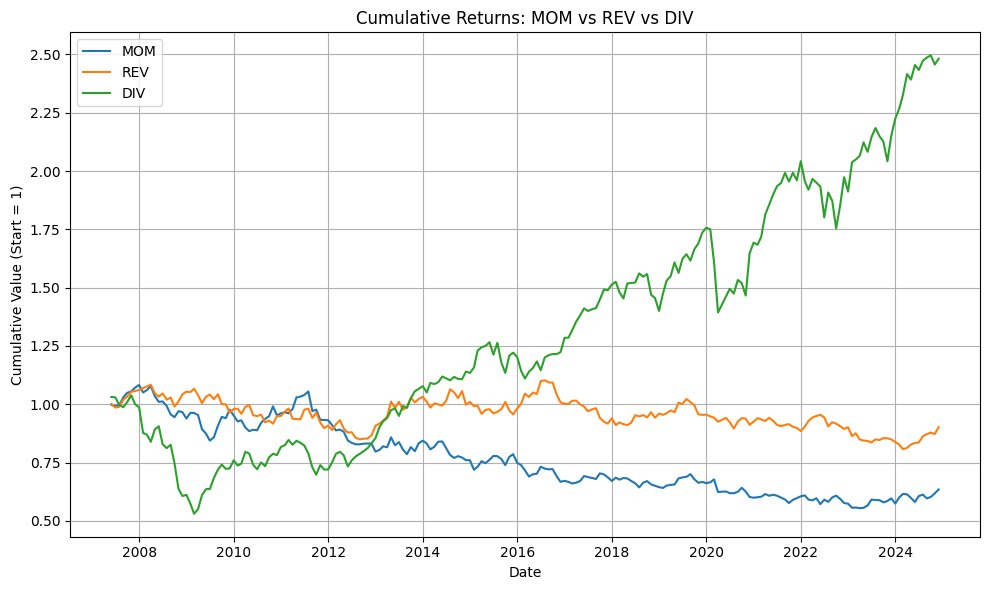

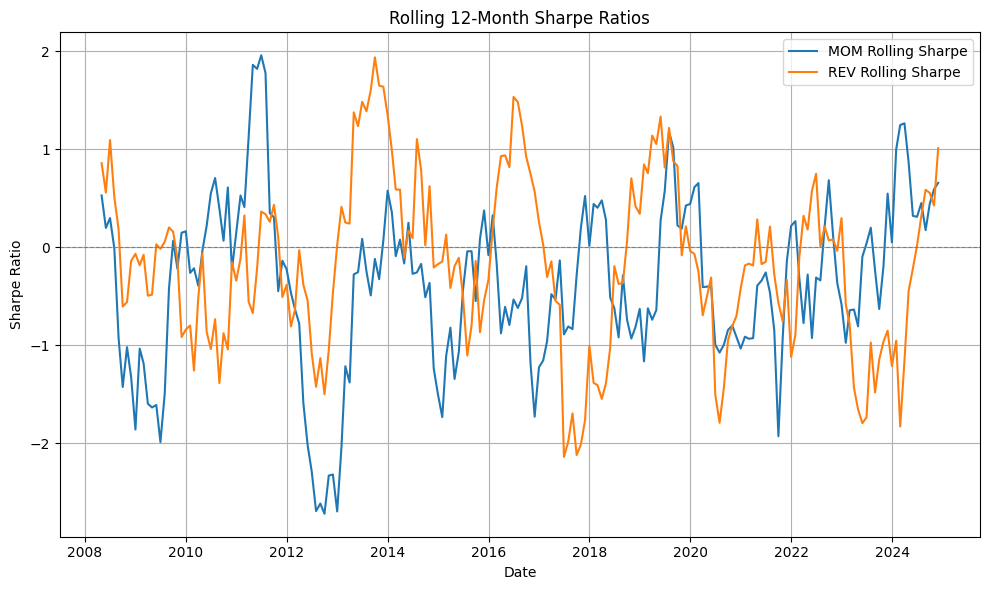

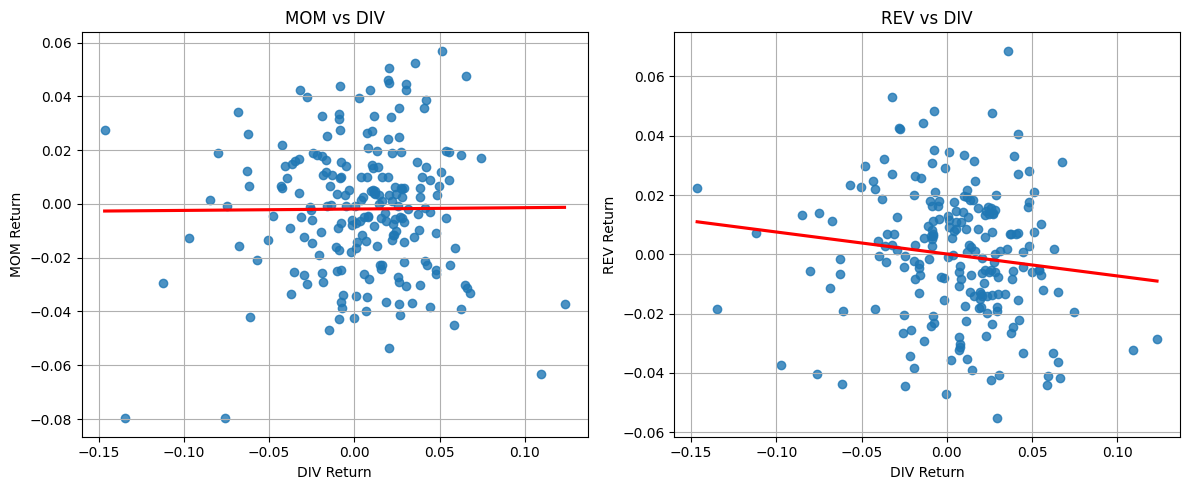

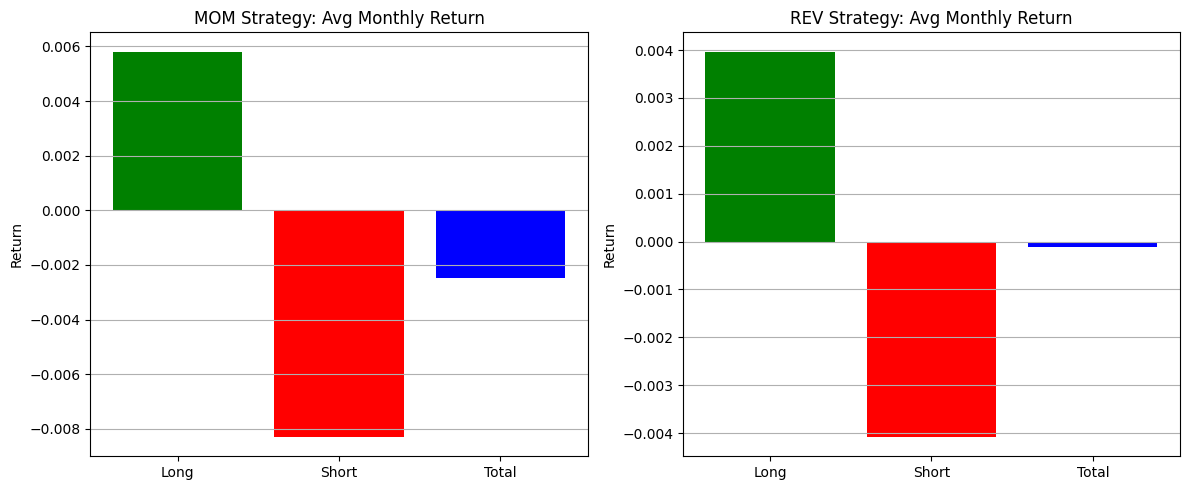

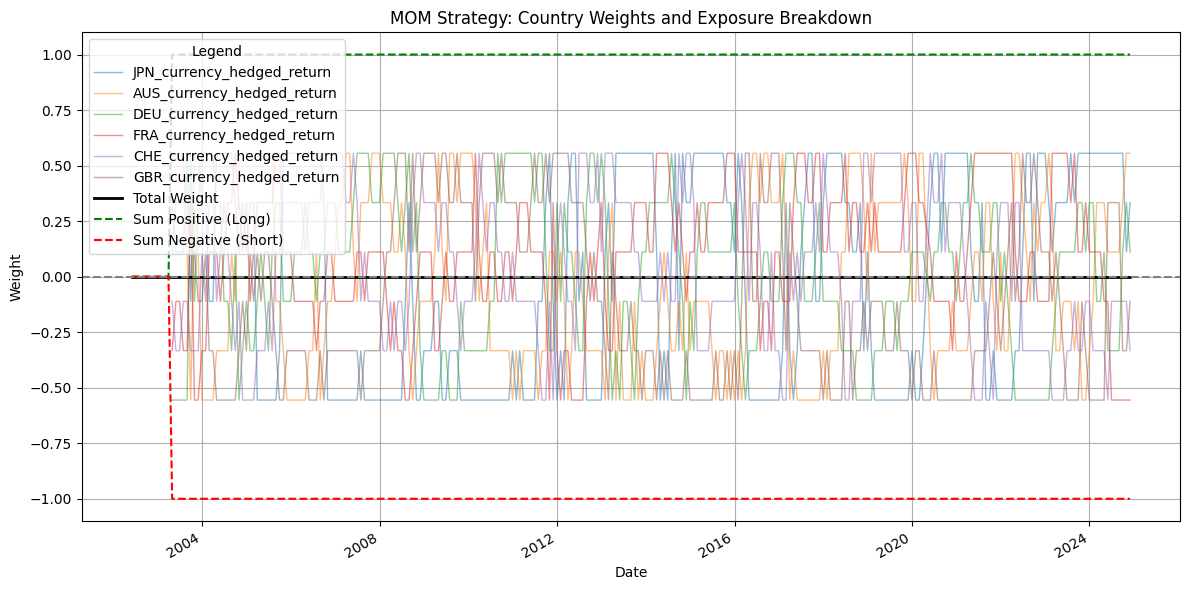

In [26]:
# === Assumed input ===
# These should be filtered already using active_mask
# mom_returns, rev_returns: Series
# mom_weights, rev_weights: DataFrames
# rp_hedged → your DIV strategy

# Step 1: Align all strategies
common_idx = mom_returns.index \
    .intersection(rev_returns.index) \
    .intersection(rp_hedged.index)

mom = mom_returns.loc[common_idx]
rev = rev_returns.loc[common_idx]
div = rp_hedged.loc[common_idx]

# === 1. Cumulative Returns ===
plt.figure(figsize=(10, 6))
plt.plot((1 + mom).cumprod(), label='MOM')
plt.plot((1 + rev).cumprod(), label='REV')
plt.plot((1 + div).cumprod(), label='DIV')
plt.title("Cumulative Returns: MOM vs REV vs DIV")
plt.ylabel("Cumulative Value (Start = 1)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Rolling 12-Month Sharpe Ratios ===
def rolling_sharpe(series, window=12):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return mean / std * np.sqrt(12)

plt.figure(figsize=(10, 6))
plt.plot(rolling_sharpe(mom), label='MOM Rolling Sharpe')
plt.plot(rolling_sharpe(rev), label='REV Rolling Sharpe')
plt.axhline(0, linestyle='--', color='gray', linewidth=0.8)
plt.title("Rolling 12-Month Sharpe Ratios")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. Scatter Plots: MOM vs DIV and REV vs DIV ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.regplot(x=div, y=mom, ax=ax[0], ci=None, line_kws={'color': 'red'})
ax[0].set_title("MOM vs DIV")
ax[0].set_xlabel("DIV Return")
ax[0].set_ylabel("MOM Return")
ax[0].grid(True)

sns.regplot(x=div, y=rev, ax=ax[1], ci=None, line_kws={'color': 'red'})
ax[1].set_title("REV vs DIV")
ax[1].set_xlabel("DIV Return")
ax[1].set_ylabel("REV Return")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# === 4. Average Monthly Return: Long, Short, Total for MOM & REV ===
def average_legs(weights, returns):
    long_w = weights.where(weights > 0, 0)
    short_w = weights.where(weights < 0, 0)
    long_ret = (long_w * returns).sum(axis=1)
    short_ret = (short_w * returns).sum(axis=1)
    total_ret = (weights * returns).sum(axis=1)
    return long_ret.mean(), short_ret.mean(), total_ret.mean()

mom_long, mom_short, mom_total = average_legs(mom_weights, currency_hedged_index_return)
rev_long, rev_short, rev_total = average_legs(rev_weights, currency_hedged_index_return)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(["Long", "Short", "Total"], [mom_long, mom_short, mom_total],
          color=["green", "red", "blue"])
ax[0].set_title("MOM Strategy: Avg Monthly Return")
ax[0].set_ylabel("Return")
ax[0].grid(True, axis='y')

ax[1].bar(["Long", "Short", "Total"], [rev_long, rev_short, rev_total],
          color=["green", "red", "blue"])
ax[1].set_title("REV Strategy: Avg Monthly Return")
ax[1].set_ylabel("Return")
ax[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

# Plot individual weights + total/long/short sums
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each country's weight
mom_weights.plot(ax=ax, linewidth=1, alpha=0.5)

# Compute sum of weights
total = mom_weights.sum(axis=1)
longs = mom_weights.where(mom_weights > 0, 0).sum(axis=1)
shorts = mom_weights.where(mom_weights < 0, 0).sum(axis=1)

# Plot sum lines
total.plot(ax=ax, color='black', linewidth=2, label='Total Weight')
longs.plot(ax=ax, color='green', linestyle='--', linewidth=1.5, label='Sum Positive (Long)')
shorts.plot(ax=ax, color='red', linestyle='--', linewidth=1.5, label='Sum Negative (Short)')

ax.axhline(0, linestyle='--', color='gray')
ax.set_title("MOM Strategy: Country Weights and Exposure Breakdown")
ax.set_ylabel("Weight")
ax.set_xlabel("Date")
ax.legend(title="Legend")
ax.grid(True)
plt.tight_layout()
plt.show()


# Question 6: Currency Carry Strategy (CARRY)

### 6.a) Construction of the return of the Carry Strategy portfolio

Calculation of the interest rate differentials ("carry") for the EUR, JPY, GBP, CHF and AUD currencies relative to the US dollar.

In [27]:
carry_df = ibexr.copy()

carry_df = carry_df.drop(columns="USD").subtract(ibexr["USD"], axis=0)

print('Interest rates differentials: \n')

print(carry_df.head())

Interest rates differentials: 

                       EUR     JPY       GBP       CHF     AUD
observation_date                                              
2002-04-30        0.015369 -0.0177  0.023032 -0.004094  0.0272
2002-05-31        0.016471 -0.0174  0.023337 -0.006565  0.0302
2002-06-30        0.016540 -0.0172  0.023676 -0.006604  0.0326
2002-07-31        0.016200 -0.0170  0.022705 -0.007869  0.0319
2002-08-31        0.016219 -0.0166  0.022565 -0.010617  0.0323


Computation of the monthly portfolio weights by ranking currencies based on their interest rate differentials and scaling them so that the sum of long positions equals +1 and the sum of short positions equals −1.

In [28]:
N = carry_df.shape[1]
ranks = carry_df.rank(axis=1, method='first') # Highest interest rate differential --> Rank: 5 
center = (N + 1) / 2                          # Lowest interest rate differential --> Rank: 1
raw_scores = ranks - center

def compute_weights(row):
    long = row.clip(lower=0)
    short = row.clip(upper=0)
    Z_long = 1 / long.sum() if long.sum() != 0 else 0
    Z_short = -1 / short.sum() if short.sum() != 0 else 0
    return long * Z_long + short * Z_short

weights = raw_scores.apply(compute_weights, axis=1)

print('Monthly weights: \n')

print(weights.head())

Monthly weights: 

                  EUR       JPY       GBP       CHF       AUD
observation_date                                             
2002-04-30        0.0 -0.666667  0.333333 -0.333333  0.666667
2002-05-31        0.0 -0.666667  0.333333 -0.333333  0.666667
2002-06-30        0.0 -0.666667  0.333333 -0.333333  0.666667
2002-07-31        0.0 -0.666667  0.333333 -0.333333  0.666667
2002-08-31        0.0 -0.666667  0.333333 -0.333333  0.666667


Computation of the currency Carry Strategy's monthly returns

In [29]:
X = excess_return_currency_in_USD.copy()

# DEU and FRA have the same currency (EUR), so the same excess return currency. Thus we drop DEU, leave FRA and rename it EU.
X = X.drop(columns='DEU_currency_excess_return', errors='ignore')

# We Rename all country-based column to  match with the labels of our weights, which are also the currency ISO codes
rename_map = {
    'JPN_currency_excess_return': 'JPY',
    'AUS_currency_excess_return': 'AUD',
    'FRA_currency_excess_return': 'EUR',
    'CHE_currency_excess_return': 'CHF',
    'GBR_currency_excess_return': 'GBP'
}

X = X.rename(columns=rename_map)

weights.index = weights.index + pd.offsets.MonthEnd(1)

X = X[weights.columns]
W = weights.loc[X.index]  

# Final formula to compute our monthly returns
carry_ret = (W * X).sum(axis=1)

print('Carry Strategy monthly returns: \n')

print(carry_ret.head())


Carry Strategy monthly returns: 

observation_date
2002-05-31    0.004056
2002-06-30   -0.042873
2002-07-31   -0.003990
2002-08-31    0.024880
2002-09-30    0.023665
dtype: float64


### 6.b) Carry Strategy Performance

 Return calculations of the long and short legs of the Carry Strategy portfolio

In [30]:
long_leg = (W.clip(lower=0) * X).sum(axis=1)
short_leg = (W.clip(upper=0) * X).sum(axis=1)

print('Long leg monthly returns: \n')
print(long_leg.head())

print('\nShort leg monthly returns: \n')
print(short_leg.head())

Long leg monthly returns: 

observation_date
2002-05-31    0.030203
2002-06-30    0.001914
2002-07-31   -0.016940
2002-08-31    0.013096
2002-09-30    0.007165
dtype: float64

Short leg monthly returns: 

observation_date
2002-05-31   -0.026148
2002-06-30   -0.044787
2002-07-31    0.012950
2002-08-31    0.011784
2002-09-30    0.016500
dtype: float64


Performance and risk analysis of the Carry Strategy, its long leg, and short leg and their statistical significance.

In [31]:
def stats_report(name, series):
    mean_monthly = series.mean()
    std_monthly = series.std()
    sharpe_monthly = mean_monthly / std_monthly if std_monthly != 0 else 0

    # Annualized results for more clarity
    mean_annual = mean_monthly * 12
    std_annual = std_monthly * np.sqrt(12)
    sharpe_annual = sharpe_monthly * np.sqrt(12)

    # t-test for significance
    n = len(series)
    t_stat = mean_monthly / (std_monthly / np.sqrt(n))
    p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 1))

    print(f"=== {name} ===")
    print(f"Annualized Mean Return: {mean_annual:.4%}")
    print(f"Annualized Std Dev: {std_annual:.4%}")
    print(f"Annualized Sharpe Ratio: {sharpe_annual:.2f}")
    print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
    print(f"Statistically significant at 5%: {'Yes' if p_val < 0.05 else 'No'}\n")

stats_report("Carry Strategy", carry_ret)
stats_report("Long Leg", long_leg)
stats_report("Short Leg", short_leg)

=== Carry Strategy ===
Annualized Mean Return: 1.7471%
Annualized Std Dev: 7.7374%
Annualized Sharpe Ratio: 0.23
t-statistic: 1.07, p-value: 0.2851
Statistically significant at 5%: No

=== Long Leg ===
Annualized Mean Return: 1.7267%
Annualized Std Dev: 7.9234%
Annualized Sharpe Ratio: 0.22
t-statistic: 1.03, p-value: 0.3022
Statistically significant at 5%: No

=== Short Leg ===
Annualized Mean Return: 0.0204%
Annualized Std Dev: 6.8574%
Annualized Sharpe Ratio: 0.00
t-statistic: 0.01, p-value: 0.9888
Statistically significant at 5%: No



### Question 6.c) Regression analysis of the Carry strategy return on the DIV return

In [50]:
# Align carry and risk parity returns
carry_trimmed = carry_ret[carry_ret.index >= '2007-05-31']

# Ensure dates match
common_dates = carry_trimmed.index.intersection(rp_hedged.index)
Y = carry_trimmed.loc[common_dates]
X = rp_hedged.loc[common_dates].to_frame(name='DIV')  # Convert to DataFrame with column name 'RP'

# Add constant and run regression
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     13.58
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           0.000291
Time:                        17:34:19   Log-Likelihood:                 495.93
No. Observations:                 210   AIC:                            -987.9
Df Residuals:                     208   BIC:                            -981.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.802      0.4

Plot of the regression of the Carry Strategy on DIV returns

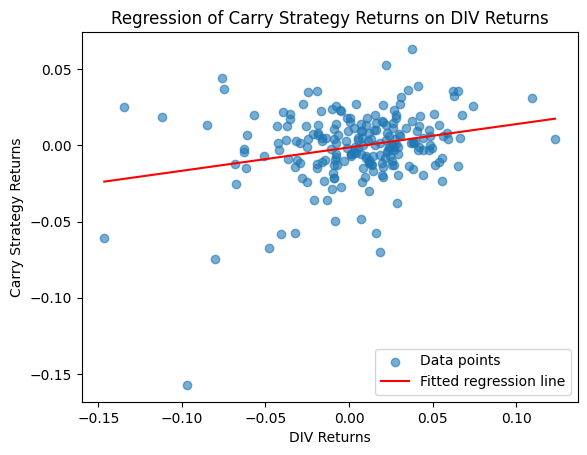

In [54]:
plt.scatter(X["DIV"], Y, alpha=0.6, label="Data points")

x_vals = np.linspace(X["DIV"].min(), X["DIV"].max(), 100)
y_vals = model.params['const'] + model.params['DIV'] * x_vals

plt.plot(x_vals, y_vals, color='red', label='Fitted regression line')

plt.xlabel("DIV Returns")
plt.ylabel("Carry Strategy Returns")
plt.title("Regression of Carry Strategy Returns on DIV Returns")
plt.legend()
plt.show()

# Question 7: Currency dollar Strategy (DOLLAR)

### 7.a) Return construction of Currency Dollar Strategy (DOLLAR)

In [37]:
X = excess_return_currency_in_USD.copy()

# DEU and FRA have the same currency (EUR), so the same excess return currency. Thus we drop DEU, leave FRA and rename it EU.
X = X.drop(columns='DEU_currency_excess_return', errors='ignore')

# We Rename all country-based column to  match with the labels of our weights, which are also the currency ISO codes
rename_map = {
    'JPN_currency_excess_return': 'JPY',
    'AUS_currency_excess_return': 'AUD',
    'FRA_currency_excess_return': 'EUR',
    'CHE_currency_excess_return': 'CHF',
    'GBR_currency_excess_return': 'GBP'
}

X = X.rename(columns=rename_map)

#Monthly return of the Dollar Strategy
dollar_returns = - X.mean(axis=1).dropna()

print('Monthly return of the Dollar Strategy: \n')

print(dollar_returns.head())

Monthly return of the Dollar Strategy: 

observation_date
2002-05-31   -0.030700
2002-06-30   -0.031830
2002-07-31    0.014650
2002-08-31   -0.002824
2002-09-30    0.002259
dtype: float64


### Question 7.b) Performance and risk analysis of the Dollar Strategy and its statistical significance.

In [38]:
def stats_report(name, series):
    mean_monthly = series.mean()
    std_monthly = series.std()
    sharpe_monthly = mean_monthly / std_monthly if std_monthly != 0 else 0

    # Annualized results for more clarity
    mean_annual = mean_monthly * 12
    std_annual = std_monthly * np.sqrt(12)
    sharpe_annual = sharpe_monthly * np.sqrt(12)

    # t-test for significance
    n = len(series)
    t_stat = mean_monthly / (std_monthly / np.sqrt(n))
    p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 1))

    print(f"=== {name} ===")
    print(f"Annualized Mean Return: {mean_annual:.4%}")
    print(f"Annualized Std Dev: {std_annual:.4%}")
    print(f"Annualized Sharpe Ratio: {sharpe_annual:.2f}")
    print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
    print(f"Statistically significant at 5%: {'Yes' if p_val < 0.05 else 'No'}\n")

stats_report("Dollar Strategy", dollar_returns)

=== Dollar Strategy ===
Annualized Mean Return: -0.4266%
Annualized Std Dev: 6.1416%
Annualized Sharpe Ratio: -0.07
t-statistic: -0.33, p-value: 0.7420
Statistically significant at 5%: No



### Question 7.c) Regression analysis of the Dollar Strategy return on the DIV returns

In [73]:
dollar_trimmed = dollar_returns[dollar_returns.index >= '2007-05-31']

# Ensure dates match
common_dates = dollar_trimmed.index.intersection(rp_hedged.index)
Y = dollar_trimmed.loc[common_dates]
X = rp_hedged.loc[common_dates].to_frame(name='DIV')  # Convert to DataFrame with column name 'RP'

# Add constant and run regression
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     13.17
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           0.000357
Time:                        17:38:59   Log-Likelihood:                 563.49
No. Observations:                 210   AIC:                            -1123.
Df Residuals:                     208   BIC:                            -1116.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.281      0.2

Plot of the regression of the Dollar Strategy on DIV returns

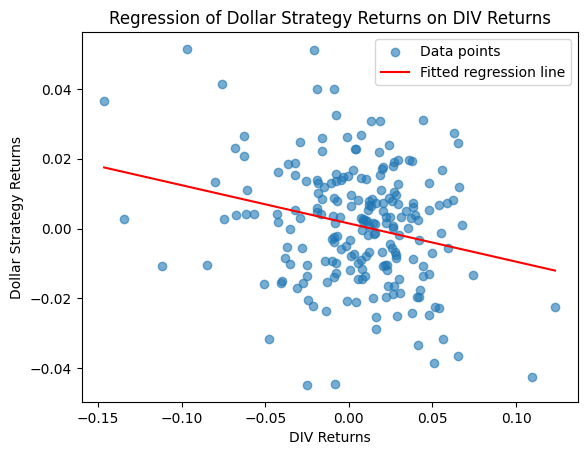

In [74]:
plt.scatter(X["DIV"], Y, alpha=0.6, label="Data points")

x_vals = np.linspace(X["DIV"].min(), X["DIV"].max(), 100)
y_vals = model.params['const'] + model.params['DIV'] * x_vals

plt.plot(x_vals, y_vals, color='red', label='Fitted regression line')

plt.xlabel("DIV Returns")
plt.ylabel("Dollar Strategy Returns")
plt.title("Regression of Dollar Strategy Returns on DIV Returns")
plt.legend()
plt.show()

Plot of the cumulative retuns of the Carry and Dollar Strategy

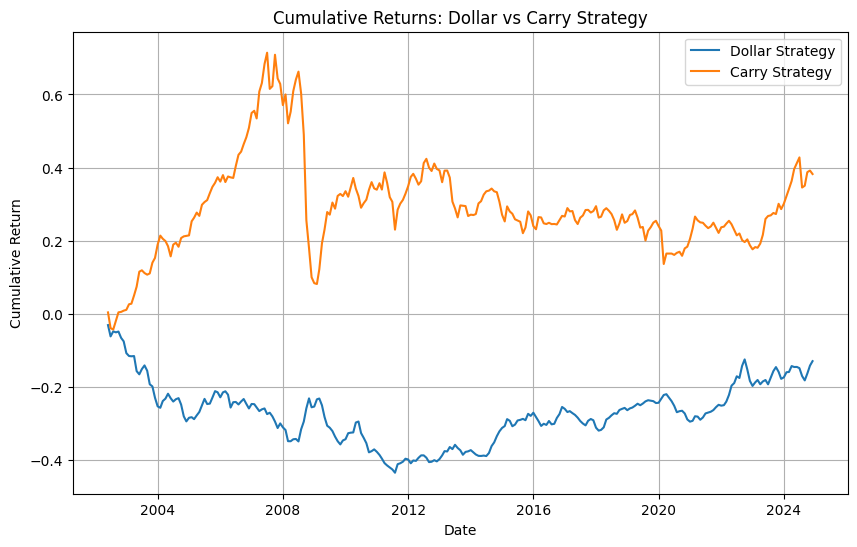

In [41]:
cum_dollar = (1 + dollar_returns).cumprod() - 1
cum_carry = (1 + carry_ret).cumprod() - 1

plt.figure(figsize=(10,6))
plt.plot(cum_dollar.index, cum_dollar, label="Dollar Strategy")
plt.plot(cum_carry.index, cum_carry, label="Carry Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns: Dollar vs Carry Strategy")
plt.legend()
plt.grid(True)
plt.show()


<Axes: xlabel='observation_date'>

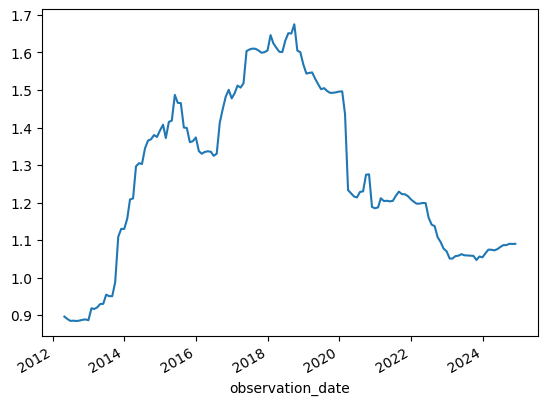

In [55]:
rolling_volatilities_DIV = pd.Series(X["DIV"].rolling(window=60, min_periods=60).std().dropna())
a = 0.15/(rolling_volatilities_DIV*np.sqrt(12))

a.plot()

## 8. Optimal fund portfolio return (STRAT)

### Question 8.1) 
We have the fund return expressed as:

$$
R_{\text{FUND}} = R_{\text{T-Bill}} + a(R_{\text{DIV}} - R_{\text{T-Bill}})
$$

Since T-Bill rates are known one period in advance and have no uncertainty, the **variance of the fund** comes only from the excess return component:

$$
\text{Var}(R_{\text{FUND}}) = a^2 \cdot \text{Var}(R_{\text{DIV}})
$$

We want the **annualized volatility** of the fund to be 15% :

$$
\text{Annualized Volatility} = a \cdot \sqrt{12 \cdot \text{Var}(R_{\text{DIV}})} = 0.15
$$

which gives us :

$$
a = \frac{0.15}{\sqrt{12 \cdot \text{Var}(R_{\text{DIV}})}}
$$

To estimate $\text{Var}(R_{\text{DIV}})$, we use a **rolling window of 60 months**. For each time $t$, we compute the rolling variance and use the formula above to obtain the corresponding value of $a_t$ that targets a 15% annual volatility.


<Axes: xlabel='observation_date'>

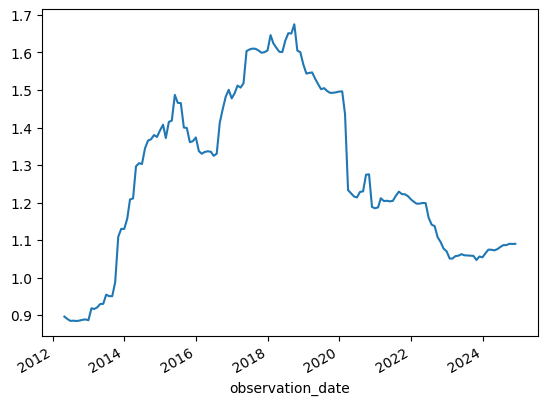

In [56]:
rolling_volatilities_DIV = pd.Series(X['DIV'].rolling(window=60, min_periods=60).std().dropna())
a = 0.15/(np.sqrt(12)*rolling_volatilities_DIV)
a.plot()

### Question 8.2)

In [57]:
# Load U.S. Interest-Bearing rate data and process it (from 3 months T-Bill to monthly)
us_ib_rate = pd.read_csv("./data/USA_IB.csv")
us_ib_rate = us_ib_rate.rename(columns={'observation_date': 'date', 'IR3TIB01USM156N': 'us_ib_rate'})
us_ib_rate['date'] = pd.to_datetime(us_ib_rate['date']).dt.to_period('M')
us_ib_rate = us_ib_rate.sort_values('date').set_index('date')
us_ib_rate['us_ib_rate'] = (1 + us_ib_rate['us_ib_rate']/100)**(1/12) - 1 
us_ib_rate

,us_ib_rate
date,
2002-04,0.001545
2002-05,0.001504
2002-06,0.001496
2002-07,0.001480
2002-08,0.001430
...,...
2024-08,0.004170
2024-09,0.003962
2024-10,0.003771


In [58]:
# Compute mean, volatility, and Sharpe Ratio with risk-parity strategy
STRAT = pd.DataFrame({'MOM':mom_returns, 'REV':rev_returns, 'CARRY':carry_ret, 'DOLLAR':dollar_returns}).dropna()
STRAT_ret, STRAT_w = risk_parity_strategy(STRAT, window=60)
STRAT_w = STRAT_w.dropna()
STRAT_ret = STRAT_ret[STRAT_ret != 0].dropna()
STRAT_mean, STRAT_vol, STRAT_sr = portfolio_performance_SR(STRAT_ret, us_ib_rate['us_ib_rate'])

mean:-0.0014801645683037627, Volatility:0.035595006715361935, Sharpe Ratio:-0.08435766474951531


<Axes: xlabel='observation_date'>

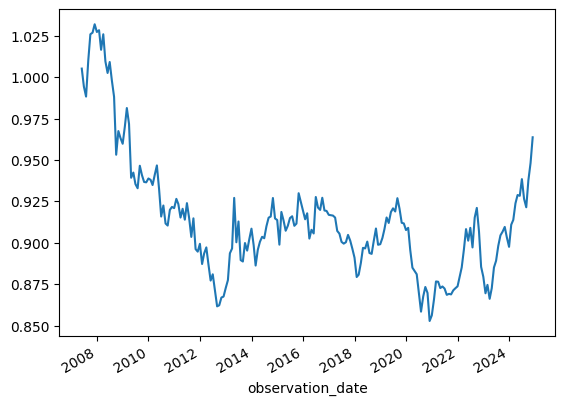

In [59]:
# Visualization
print(f"mean:{STRAT_mean}, Volatility:{STRAT_vol}, Sharpe Ratio:{STRAT_sr}")
STRAT_cumret = (1+STRAT_ret).cumprod()
STRAT_cumret.plot()

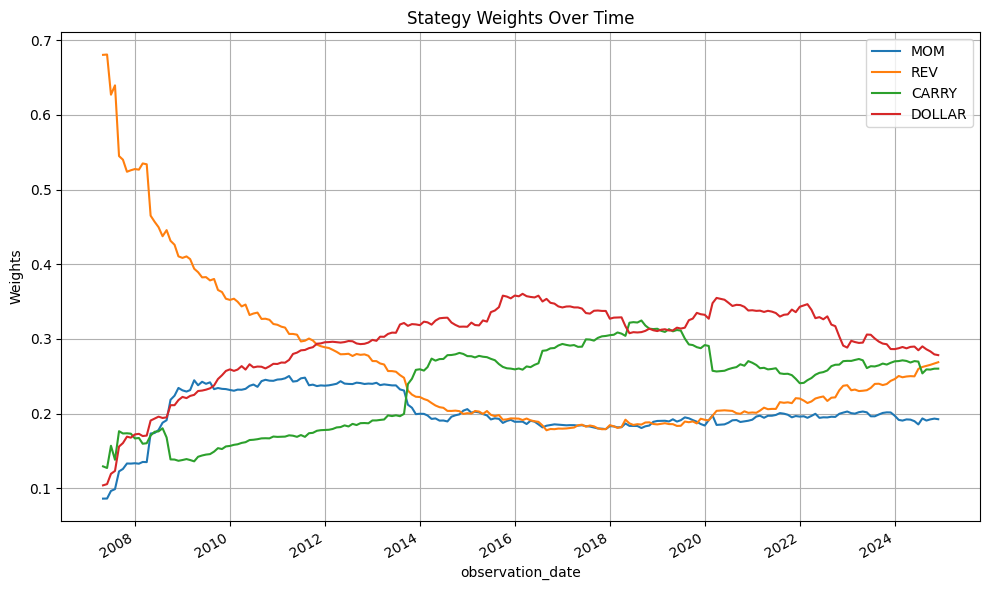

In [60]:
# Plotting the strategy weights over time
fig, ax = plt.subplots(figsize=(10, 6))
STRAT_w.plot(ax = ax)
ax.set_title("Stategy Weights Over Time")
ax.set_ylabel("Weights")
plt.grid(True)
plt.tight_layout()
plt.show()

### Question 8.3)

We need to determine the weights of $(R_{DIV} - R_{T-Bill})$ and $R_{STRAT}$ for a mean variance investor

In [61]:
# Load T-Bill data and process it
tbill = pd.read_csv('./data/tbill.csv', sep=';').rename(columns={'mcaldt': 'date', 'tmytm': 'rate'})
tbill['rate'] = (1 + tbill['rate']/100)**(1/12)-1
tbill['date'] = pd.to_datetime(tbill['date'])
tbill = tbill.set_index('date')
tbill

,rate
date,
2002-01-31,0.001397
2002-02-28,0.001433
2002-03-28,0.001414
2002-04-30,0.001449
2002-05-31,0.001397
...,...
2024-08-30,0.004278
2024-09-30,0.003748
2024-10-31,0.003677


In [62]:
# Create R_DIV, R_Tbill and R_STRAT
rdiv_rtbill_rstrat = pd.DataFrame({'DIV-Tbill':X['DIV']-tbill['rate'],'STRAT':STRAT_ret}).dropna()

In [63]:
# Function to compute tangency portfolio returns using MVO
def tangency_returns_mvo(returns: pd.DataFrame,rf : pd.Series,window:int=60)->pd.Series:
    # Align indexes of returns and risk-free rate
    common_index = returns.index.intersection(rf.index)
    returns = returns.loc[common_index]
    rf =rf.loc[common_index]
    # number of periods in the dataset
    n_periods = len(returns)
    # asset names
    a_names = returns.columns
    # stores portfolio weights
    pf_weights = []
    for t in range(window, n_periods):
        window_start = t-window
        window_end = t
        # Current window of returns
        window_position = returns.iloc[window_start:window_end]
        # rf of the previous period in the window
        rf_t =rf.iloc[t-1] 
        # Compute mean and covariance matrix of the window
        window_position_mean = window_position.mean()
        window_position_cov = window_position.cov()
        # Calculate excess returns over the risk-free rate
        window_excess_return = window_position_mean-rf_t
        # Formating
        period_w = pd.Series(np.zeros(len(a_names)), index=a_names) 
        cov_matrix = window_position_cov.to_numpy()
        excess_returns = window_excess_return.to_numpy()
        # Inverse covariance matrix
        inv_cov=np.linalg.inv(cov_matrix)
        # Calculate raw weights using the inverse covariance matrix and excess returns
        raw_weights = inv_cov@excess_returns 
        period_w = pd.Series(raw_weights, index=a_names)
        pf_weights.append(period_w)
    weights = pd.concat(pf_weights, axis=1).T
    weights.index = returns.index[window : n_periods]
    relevant_asset_returns = returns.iloc[window : n_periods]
    portfolio_returns = (weights * relevant_asset_returns).sum(axis=1)
    return portfolio_returns, weights

In [64]:
MVO_RET_FUND, MVO_FUND_weights= tangency_returns_mvo(rdiv_rtbill_rstrat, tbill['rate'], 60)
weights_lst = []
indexes = []
# Loop over each rolling window
for t in range(60,len(rdiv_rtbill_rstrat)): 
    rolling_window = rdiv_rtbill_rstrat.iloc[t-60:t-1]
    mu = rolling_window.mean().values
    sigma = rolling_window.cov().values
    # Formula: w = 0.15 * inv(sigma) * mu / sqrt(12 * mu.T * inv(sigma) * mu)
    w = 0.15*np.linalg.inv(sigma)@mu/np.sqrt(12*mu@np.linalg.inv(sigma)@mu)
    weights_lst.append(w)
    indexes.append(rdiv_rtbill_rstrat.index[t])
FUND_w = pd.DataFrame(weights_lst, index = indexes, columns = ['b','c'])
FUND_ret = (tbill['rate'] + FUND_w['b']*rdiv_rtbill_rstrat['DIV-Tbill'] + FUND_w['c']*STRAT_ret).dropna()
FUND_cumret = (1+FUND_ret).cumprod()

In [65]:
all_strat_w = pd.DataFrame({'DOLLAR' : FUND_w['c']*STRAT_w['DOLLAR'],'CARRY' : FUND_w['c']*STRAT_w['CARRY'],'MOM' : FUND_w['c']*STRAT_w['MOM'],
                                       'REV' : FUND_w['c']*STRAT_w['REV'],'DIV' : FUND_w['b'],'T-bill' : 1-FUND_w['b']  }).dropna()
all_strat_w

,DOLLAR,CARRY,MOM,REV,DIV,T-bill
2014-06-30,-0.982123,-0.817561,-0.571030,-0.621873,0.350098,0.649902
2014-07-31,-0.997111,-0.844735,-0.575507,-0.618330,0.320718,0.679282
2014-09-30,-0.937860,-0.821925,-0.581879,-0.600230,0.375897,0.624103
2014-10-31,-0.974369,-0.866512,-0.613180,-0.626403,0.345195,0.654805
2014-12-31,-0.996776,-0.872950,-0.649370,-0.632231,0.298120,0.701880
...,...,...,...,...,...,...
2024-04-30,-0.140454,-0.130295,-0.093200,-0.121448,1.066584,-0.066584
2024-05-31,-0.079754,-0.074396,-0.052272,-0.068786,1.084645,-0.084645
2024-07-31,0.007090,0.006207,0.004733,0.006417,1.106778,-0.106778
2024-09-30,0.034734,0.031745,0.023575,0.032524,1.112953,-0.112953


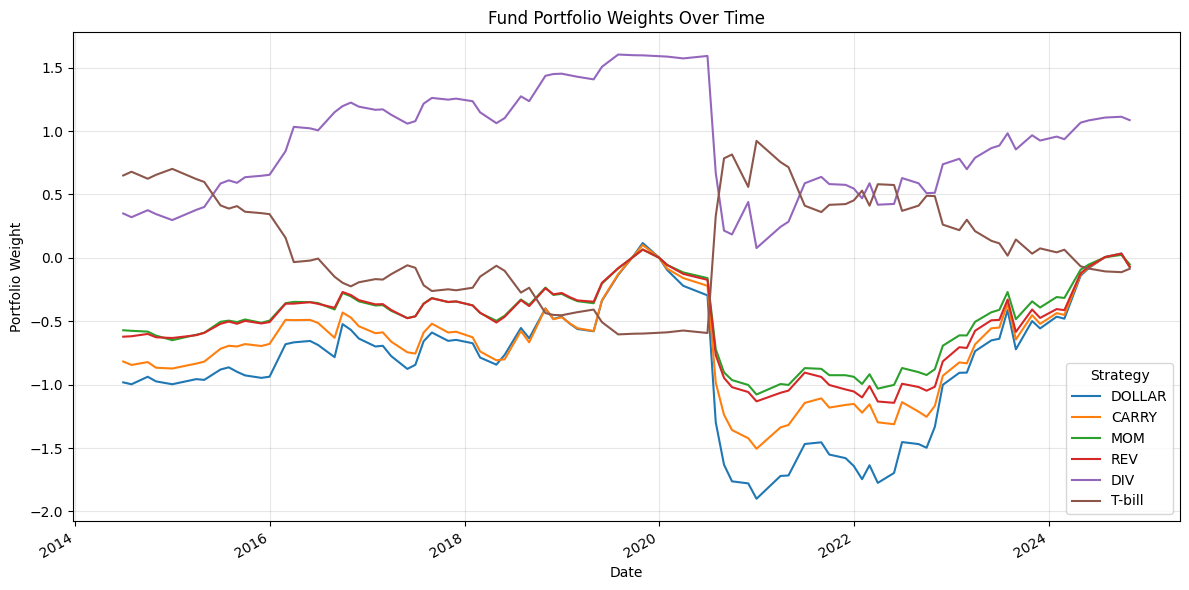

In [66]:
# Plotting the weights of all strategies with improved labels
ax = all_strat_w.plot(figsize=(12, 6))
ax.set_title("Fund Portfolio Weights Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio Weight")
plt.legend(title="Strategy")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Question 8.4)

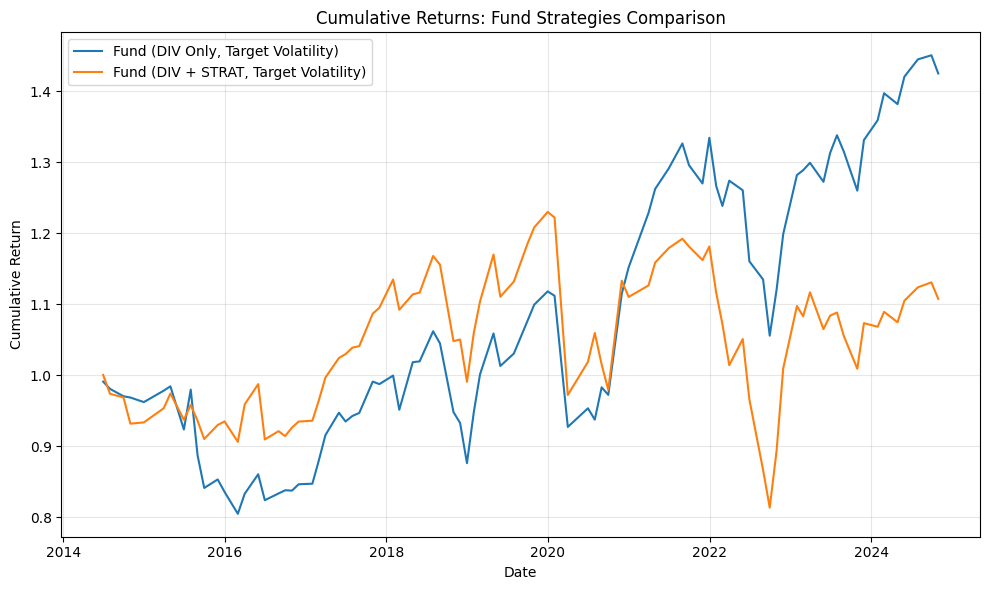

In [67]:
FUND_alt_ret = (tbill['rate']+a*(X['DIV']-tbill['rate'])).loc[FUND_ret.index].dropna()
FUND_alt_cumret = (1+FUND_alt_ret).cumprod() 
plt.figure(figsize=(10, 6))
plt.plot(FUND_alt_cumret.loc[FUND_cumret.index], label='Fund (DIV Only, Target Volatility)')
plt.plot(FUND_cumret,label='Fund (DIV + STRAT, Target Volatility)')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns: Fund Strategies Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [68]:
# Calculate performance metrics
FUND_mean, vol_FUND, SR_FUND = portfolio_performance_SR(FUND_ret, us_ib_rate['us_ib_rate'])
FUND_mean_alt, vol_FUND_alt, SR_FUND_alt = portfolio_performance_SR(FUND_alt_ret, us_ib_rate['us_ib_rate'])
print("Fund Performance Comparison")
print("=" * 35)
print(f"{'':<25} {'Mean':>8} {'Volatility':>12} {'Sharpe Ratio':>15}")
print(f"{'With STRAT':<25} {FUND_mean:.4f}   {vol_FUND:.4f}      {SR_FUND:.2f}")
print(f"{'Without STRAT':<25} {FUND_mean_alt:.4f}   {vol_FUND_alt:.4f}      {SR_FUND_alt:.2f}")

Fund Performance Comparison
                              Mean   Volatility    Sharpe Ratio
With STRAT                0.0288   0.1706      0.16
Without STRAT             0.0611   0.1555      0.38


## 9. Performance and risk analysis for the Fund strategy

In [69]:
FUND_ret.index = pd.to_datetime(FUND_ret.index).to_period('M')
FUND_ret

2014-06    0.000496
2014-07   -0.026636
2014-09   -0.005190
2014-10   -0.038048
2014-12    0.001861
             ...   
2024-04   -0.013504
2024-05    0.028282
2024-07    0.017045
2024-09    0.006197
2024-10   -0.020544
Freq: M, Length: 87, dtype: float64

In [70]:
fama_french_factors = pd.read_csv("./data/ff_factors.csv")
fama_french_factors['date'] = pd.to_datetime(fama_french_factors['date'], format='%Y%m').dt.to_period('M')
fama_french_factors = fama_french_factors.set_index('date', inplace  = False)
fama_french_factors = fama_french_factors/100
fama_french_factors = fama_french_factors.loc[FUND_ret.index]
fama_french_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
2014-06,0.0261,0.0306,-0.0071,-0.0183,-0.0191,0.0000
2014-07,-0.0203,-0.0420,-0.0008,0.0093,0.0051,0.0000
2014-09,-0.0196,-0.0366,-0.0147,0.0120,-0.0059,0.0000
2014-10,0.0251,0.0366,-0.0163,-0.0039,0.0021,0.0000
2014-12,-0.0005,0.0283,0.0212,-0.0121,0.0090,0.0000
...,...,...,...,...,...,...
2024-04,-0.0465,-0.0248,-0.0047,0.0161,-0.0031,0.0047
2024-05,0.0432,0.0068,-0.0136,0.0335,-0.0285,0.0044
2024-07,0.0122,0.0835,0.0562,0.0027,0.0028,0.0045
2024-09,0.0173,-0.0091,-0.0277,0.0018,-0.0029,0.0040


In [71]:
# Run OLS regression of FUND returns on Fama-French factors
y = FUND_ret
X = fama_french_factors
X = sm.add_constant(X)
model_FUND_on_FF = sm.OLS(y,X).fit()
print(model_FUND_on_FF.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     25.59
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           9.33e-17
Time:                        17:38:10   Log-Likelihood:                 185.60
No. Observations:                  87   AIC:                            -357.2
Df Residuals:                      80   BIC:                            -339.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.004     -0.999      0.3